# CS444 PROJECT
## PERCEPTION CHALLENGE FOR BIN-PICKING BY OPENCV AND INTRINSIC

### 1. Converting BOP dataset to YOLO format

Run this only once to generate the text files

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
from tqdm import tqdm
from pathlib import Path
import cv2
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
def clean_file_list(path):
    return sorted([
        f for f in os.listdir(path)
        if not f.startswith('.') and os.path.isfile(os.path.join(path, f))
    ])

In [3]:
def convert_bop_to_yolo(data_dir, data):

    # get folders in path
    folders = os.listdir(data_dir)
    folders.sort()
    cam = ["cam1","cam2","cam3"]

    class_names = {
            0: 0,
            8: 1,
            18: 2,
            19: 3,
            20: 4,
            1: 5,
            4: 6,
            10: 7,
            11: 8,
            14: 9
        }

    # image and label data
    rgb_img_dir = []
    aolp_img_dir = []
    dolp_img_dir = []
    depth_img_dir = []
    mask_img_dir = []
    maskvisb_img_dir = []

    img_h, img_w = 2400, 2400

    # Splitting data into train val and test
    if data == "train":
        # img_h, img_w = 2400, 2400
        f = folders[0]
    elif data == "val":
        f = folders[1]
    else:
        f = folders[2]
        # img_h, img_w = 2160, 3840    
    
    labels = []
    camera_info = []
    camera_transforms = []

    # f = folders[0]
    # folderno = 0 
    # for f in tqdm(folders):
    #     folderno += 1
    for c in cam:

        # load data
        rgb_img_path = os.path.join(data_dir, f, f"rgb_{c}")
        aolp_img_path = os.path.join(data_dir, f, f"aolp_{c}")
        dolp_img_path = os.path.join(data_dir, f, f"dolp_{c}")
        depth_img_path = os.path.join(data_dir, f, f"depth_{c}")
        bbox_path = os.path.join(data_dir, f, f"scene_gt_info_{c}.json")
        obj_id__path = os.path.join(data_dir, f, f"scene_gt_{c}.json")

        
        # Get image paths          
        rgb_imgs = clean_file_list(rgb_img_path)
        aolp_imgs = clean_file_list(aolp_img_path)
        dolp_imgs = clean_file_list(dolp_img_path)
        depth_imgs = clean_file_list(depth_img_path)
        
        # Prepping masked images
        # if data == "train":
        mask_img_path = os.path.join(data_dir, f, f"mask_{c}")
        maskvisb_img_path = os.path.join(data_dir, f, f"mask_visib_{c}")
        mask_imgs = clean_file_list(mask_img_path)
        mask_imgs = list(map(lambda img: os.path.join(mask_img_path, img), mask_imgs))
        mask_grouped = defaultdict(list)
        for p in mask_imgs:
            fname = os.path.basename(p)
            prefix = fname.split('_')[0]  
            mask_grouped[prefix].append(p)
        mask_imgs = list(mask_grouped.values())
        
        maskvisb_imgs = clean_file_list(maskvisb_img_path)
        maskvisb_imgs = list(map(lambda img: os.path.join(maskvisb_img_path, img), maskvisb_imgs))
        maskvisb_grouped = defaultdict(list)
        for p in maskvisb_imgs:
            fname = os.path.basename(p)
            prefix = fname.split('_')[0]  
            maskvisb_grouped[prefix].append(p)
        maskvisb_imgs = list(maskvisb_grouped.values())
        
        # Get Box data
        with open(bbox_path) as bbox_file:
            bbox_data = json.load(bbox_file)
    
        # Get img object id data
        with open(obj_id__path) as obj_id_file:
            obj_data = json.load(obj_id_file)

        for i,b in enumerate(obj_data):
            
            obj_no = len(bbox_data[b])     
            rgb_img_p = (f"{rgb_img_path}/{rgb_imgs[i]}")
            rgb_img_dir.append(rgb_img_p)
            aolp_img_dir.append(f"{aolp_img_path}/{aolp_imgs[i]}")
            dolp_img_dir.append(f"{dolp_img_path}/{dolp_imgs[i]}")
            depth_img_dir.append(f"{depth_img_path}/{depth_imgs[i]}")
            # if data == "train":
            mask_img_dir.append(mask_imgs[i])
            maskvisb_img_dir.append(maskvisb_imgs[i])
                # maskvisb_img_dir.append(f"{maskvisb_img_path}/{maskvisb_imgs[i]}")
            
            label = []
            camera_transform = []
            for j in range(obj_no):
                
                x,y,w,h = bbox_data[b][j]['bbox_obj'] 
                obj_id = class_names[obj_data[b][j]['obj_id']]
                # img = cv2.imread(rgb_img_p) 

                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                w_norm = w / img_w
                h_norm = h / img_h

                camera_transform.append({'cam_R_m2c' : obj_data[b][j]['cam_R_m2c'], 'cam_t_m2c' : obj_data[b][j]['cam_t_m2c']})
                label.append([obj_id, x_center, y_center, w_norm, h_norm])

            labels.append(label)
            camera_info.append(c)
            camera_transforms.append(camera_transform)


    image_dirs = [rgb_img_dir, aolp_img_dir, dolp_img_dir, mask_img_dir, maskvisb_img_dir, depth_img_dir]
    print(f"Image and labels converted for {data} data...")
    return image_dirs, labels, camera_info, camera_transforms

In [4]:
def save_dataset_as_json(image_dirs, labels, camera_info, camera_transforms, output_path, data_type):
    rgb_dir, aolp_dir, dolp_dir, mask_dir, maskvisb_dir, depth_dir = image_dirs

    data = {}
    for i in range(len(rgb_dir)):
        entry = {
            "rgb": rgb_dir[i],
            "depth": depth_dir[i],
            "aolp": aolp_dir[i],
            "dolp": dolp_dir[i],
            "mask": mask_dir[i],
            "mask_visb": maskvisb_dir[i],
            "labels": [
                [int(obj[0]), round(obj[1], 6), round(obj[2], 6), round(obj[3], 6), round(obj[4], 6)]
                for obj in labels[i]
            ],
            "camera_info":camera_info[i],
            "camera_transforms": camera_transforms[i]
        }
        data[str(i)] = entry

    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved {data_type} data at ./{output_path} ...")


Due to limitations of GPU dividing the training dataset into train validation and test.

In [5]:
data_dir = "./ipd/train_pbr"

data = "train"
output_json = "train_data.json"
image_dirs, labels, camera_info, camera_transforms = convert_bop_to_yolo(data_dir, data)
save_dataset_as_json(image_dirs, labels, camera_info, camera_transforms, output_json, data)

data = "val"
output_json = "val_data.json"
image_dirs, labels, camera_info, camera_transforms =  convert_bop_to_yolo(data_dir, data)
save_dataset_as_json(image_dirs, labels, camera_info, camera_transforms, output_json, data)

data = "test"
output_json = "test_data.json"
image_dirs, labels, camera_info, camera_transforms =  convert_bop_to_yolo(data_dir, data)
save_dataset_as_json(image_dirs, labels, camera_info, camera_transforms, output_json, data)



Image and labels converted for train data...
Saved train data at ./train_data.json ...
Image and labels converted for val data...
Saved val data at ./val_data.json ...
Image and labels converted for test data...
Saved test data at ./test_data.json ...


### 2. Custom Data Loader

In [1]:
from ultralytics import YOLO
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader,Dataset
import cv2
import os
import json
import matplotlib.pyplot as plt
import random
import numpy as np
import trimesh
from scipy.spatial.transform import Rotation as Rscipy

In [2]:
class CustomYOLODataset(Dataset):

    def __init__(self, data_dir, mesh, camera_internsics, img_type_list=["rgb"], transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_type_list = img_type_list
        self.class_names = {
            0: 0,
            1: 8,
            2: 18,
            3: 19,
            4: 20,
            5: 1,
            6: 4,
            7: 10,
            8: 11,
            9: 14
        }

        with open(data_dir, "r") as f:
            self.data_files = json.load(f)

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        
        idx = str(idx)
        sample = self.data_files[idx]
        camera = sample["camera_info"]
        camera_transforms = sample["camera_transforms"]
        cam_type       = camera
        intr           = camera_internsics[cam_type]
        fx, fy, cx, cy = intr["fx"], intr["fy"], intr["cx"], intr["cy"]

        orig_width = 3840
        orig_height = 2160
        new_width = 2400
        new_height = 2400     
        offset = -70
        # Cropping offset
        crop_offset_x = ((orig_width - new_width) / 2) - offset  
        crop_offset_y = (orig_height - new_height) / 2 
        
        cx_new = cx - crop_offset_x
        cy_new = cy  - crop_offset_y
        fx_new = fx
        fy_new = fy
        
        K = np.array([[fx_new, 0, cx_new],
                      [0, fy_new, cy_new],
                      [0,  0,  1]], dtype=np.float32)


        
        
        margin = 10 # e.g. 10 pixels margin
        input_size = 256
        # Randomize the labels for train
        if self.data_dir == "./train_data.json":
            sample_idx = random.sample(range(len(sample["labels"])), 5)
        else:
            # validation and test will have the same bboxes
            sample_idx = list(range(len(sample["labels"])))[1:6]   

        labels = [sample["labels"][ind] for ind in sample_idx]
        labels = torch.tensor(labels, dtype=torch.float32)
        
        images = {}

        mask_img_path = sample.get("mask")
        mask_image = []
        for ind in sample_idx:
            mask_image.append(self.transform(cv2.cvtColor(cv2.imread(mask_img_path[ind]), cv2.COLOR_BGR2RGB)))

        # Original Mask
        mask_image1 = cv2.imread(mask_img_path[sample_idx[0]])
        mask_image2 = cv2.imread(mask_img_path[sample_idx[1]])
        mask_image3 = cv2.imread(mask_img_path[sample_idx[2]])
        mask_image4 = cv2.imread(mask_img_path[sample_idx[3]])
        mask_image5 = cv2.imread(mask_img_path[sample_idx[4]])
        mask_image_rgb = np.bitwise_or.reduce([mask_image1, mask_image2, mask_image3, mask_image4,mask_image5])

        masks = torch.stack([
                mask_image[0],
                mask_image[1],
                mask_image[2],
                mask_image[3],
                mask_image[4],
            ], dim=0)                        # shape: (5, C, H, W)
        mask_bool = masks.bool().any(dim=0)   # shape: (C,H,W)
            
        for img_type in self.img_type_list:
            # img_path = sample.get(img_type)
            # if not img_path:
            #     raise FileNotFoundError(f"Image path for type '{img_type}' not found in sample {idx}")
            # cropping rgb data for training pose model
            
            if img_type == "rgb_cropped":
                image = []
                R_6d = []
                img_path = sample.get("rgb")
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.bitwise_and(img, mask_image_rgb)
                h,  w   = 2400, 2400

                for ind in sample_idx:
                    # image for pose prediction
                    bbox = sample["labels"][ind]
                    cls, cx, cy, bw, bh = bbox
                
                    x1 = (cx - bw / 2) * w  
                    y1 = (cy - bh / 2) * h
                
                
                    x2 = (cx + bw / 2) * w
                    y2 = (cy + bh / 2) * h
                
                
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w - 1, x2), min(h - 1, y2)
                    
                    # x_min, y_min = max(0, x1-margin), max(0, y1-margin)
                    # x_max, y_max = min(w -1, x2+margin),min(h -1, y2+margin)

                    x_min, y_min = int(max(0, x1 - margin)), int(max(0, y1 - margin))
                    x_max, y_max = int(min(w - 1, x2 + margin)), int(min(h - 1, y2 + margin))

                    
                    crop_rgb = img[y_min:y_max+1, x_min:x_max+1]
                    crop_h, crop_w = crop_rgb.shape[0], crop_rgb.shape[1]
                    
                    crop_rgb_resized = cv2.resize(crop_rgb, (input_size, input_size),interpolation=cv2.INTER_LINEAR)
                    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])

                    
                    tensor_transform = T.Compose([T.ToTensor(), 
                                                            normalize,
                                                            ])
                    input_tensor = tensor_transform(crop_rgb_resized)
                    image.append(input_tensor)

                    # generating labels for pose prediction
                    rotation = camera_transforms[ind]['cam_R_m2c']
                    rotation = np.array(rotation, dtype=np.float32).reshape(3, 3)
                    transpose = camera_transforms[ind]['cam_t_m2c']
            
                    transpose = np.array(transpose, dtype=np.float32).reshape(3, 1)
                    rotation = Rscipy.from_matrix(rotation)
                    euler = rotation.as_euler('zyx', degrees=False)
                    R_6d.append(torch.tensor(np.concatenate([transpose.flatten(), euler]), dtype=torch.float32))

                    
            elif img_type == "mask":
                image = mask_image
            else:
                img_path = sample.get(img_type)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # image = torch.tensor(image, dtype=torch.float32)
                image = self.transform(image)

                # Applying mask
                if mask_bool.ndim == 2:
                    mask_bool = mask_bool.unsqueeze(0).expand_as(image)  # now (C,H,W)
                image = image* mask_bool.to(image.dtype)
            
            images[img_type] = image

        return images, labels, camera, camera_transforms, R_6d




Load RGB and Depth images

In [3]:
# Create datasets and dataloaders
transform = T.Compose([
    T.ToTensor(),
    T.Resize((640, 640)),  # resize to YOLO input size
])

train_dir = "./train_data.json"
val_dir = "./val_data.json"
test_dir = "./test_data.json"

image_type = ["rgb","depth","mask", "rgb_cropped"]

with open("./ipd/camera_cam1.json") as cam1_int:
    cam1_internsics = json.load(cam1_int)
with open("./ipd/camera_cam2.json") as cam2_int:
    cam2_internsics = json.load(cam2_int)
with open("./ipd/camera_cam3.json") as cam3_int:
    cam3_internsics = json.load(cam3_int)
camera_internsics = {"cam1":cam1_internsics,"cam2":cam2_internsics,"cam3":cam3_internsics}


mesh = {0: trimesh.load('ipd/models/obj_000000.ply'), 
     1: trimesh.load('ipd/models/obj_000008.ply'),
     2: trimesh.load('ipd/models/obj_000018.ply'),
     3: trimesh.load('ipd/models/obj_000019.ply'),
     4: trimesh.load('ipd/models/obj_000020.ply'),
     5: trimesh.load('ipd/models/obj_000001.ply'),
     6: trimesh.load('ipd/models/obj_000004.ply'),
     7: trimesh.load('ipd/models/obj_000010.ply'),
     8: trimesh.load('ipd/models/obj_000011.ply'),
     9: trimesh.load('ipd/models/obj_000014.ply')}


batch_size = 16

# Create the dataset
train_dataset = CustomYOLODataset(train_dir, mesh, camera_internsics, image_type, transform=transform)
val_dataset = CustomYOLODataset(val_dir, mesh, camera_internsics, image_type, transform=transform)
test_dataset = CustomYOLODataset(test_dir, mesh, camera_internsics, image_type, transform=transform)


# Load the dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Validating dataloader

In [4]:
def plot_sample_images(dataloader, image_type, num_images=3):
    # Fetch one batch
    for images, targets,_,_,_ in dataloader:
        break  # Only grab the first batch

    # Randomly choose 3 indices from the batch
    indices = random.sample(range(len(images)), num_images)

    num_types = len(image_type)

    # fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig, axs = plt.subplots(len(indices), 4, figsize=(5 * 4, 5 * len(indices)))
    if len(indices) == 1:
        axs = axs[np.newaxis, :]
    if num_types == 1:
        axs = axs[:, np.newaxis]

    for i, idx in enumerate(indices):
        for j,img_type in enumerate(image_type):

            ax = axs[i, j]
            if img_type == "mask" or img_type == "rgb_cropped":
                image = images[idx][img_type][0]
                image_np = image.permute(1, 2, 0).numpy()  # [H, W, C]
                # continue
            else:
                image = images[idx][img_type]  # [C, H, W]
                
                boxes = targets[idx]  # (N, 5)
                image_np = image.permute(1, 2, 0).numpy()  # [H, W, C]
                h, w = image_np.shape[:2]
        
                for box in boxes:
                    cls, cx, cy, bw, bh = box
                    x = (cx - bw / 2) * w
                    y = (cy - bh / 2) * h
                    width = bw * w
                    height = bh * h
        
                    rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y - 5, f"Object {int(cls)}", color='yellow', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.imshow(image_np)
            ax.axis("off")
            ax.set_title(f"{img_type} Sample {idx}")

    plt.tight_layout()
    plt.show()



##### Training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


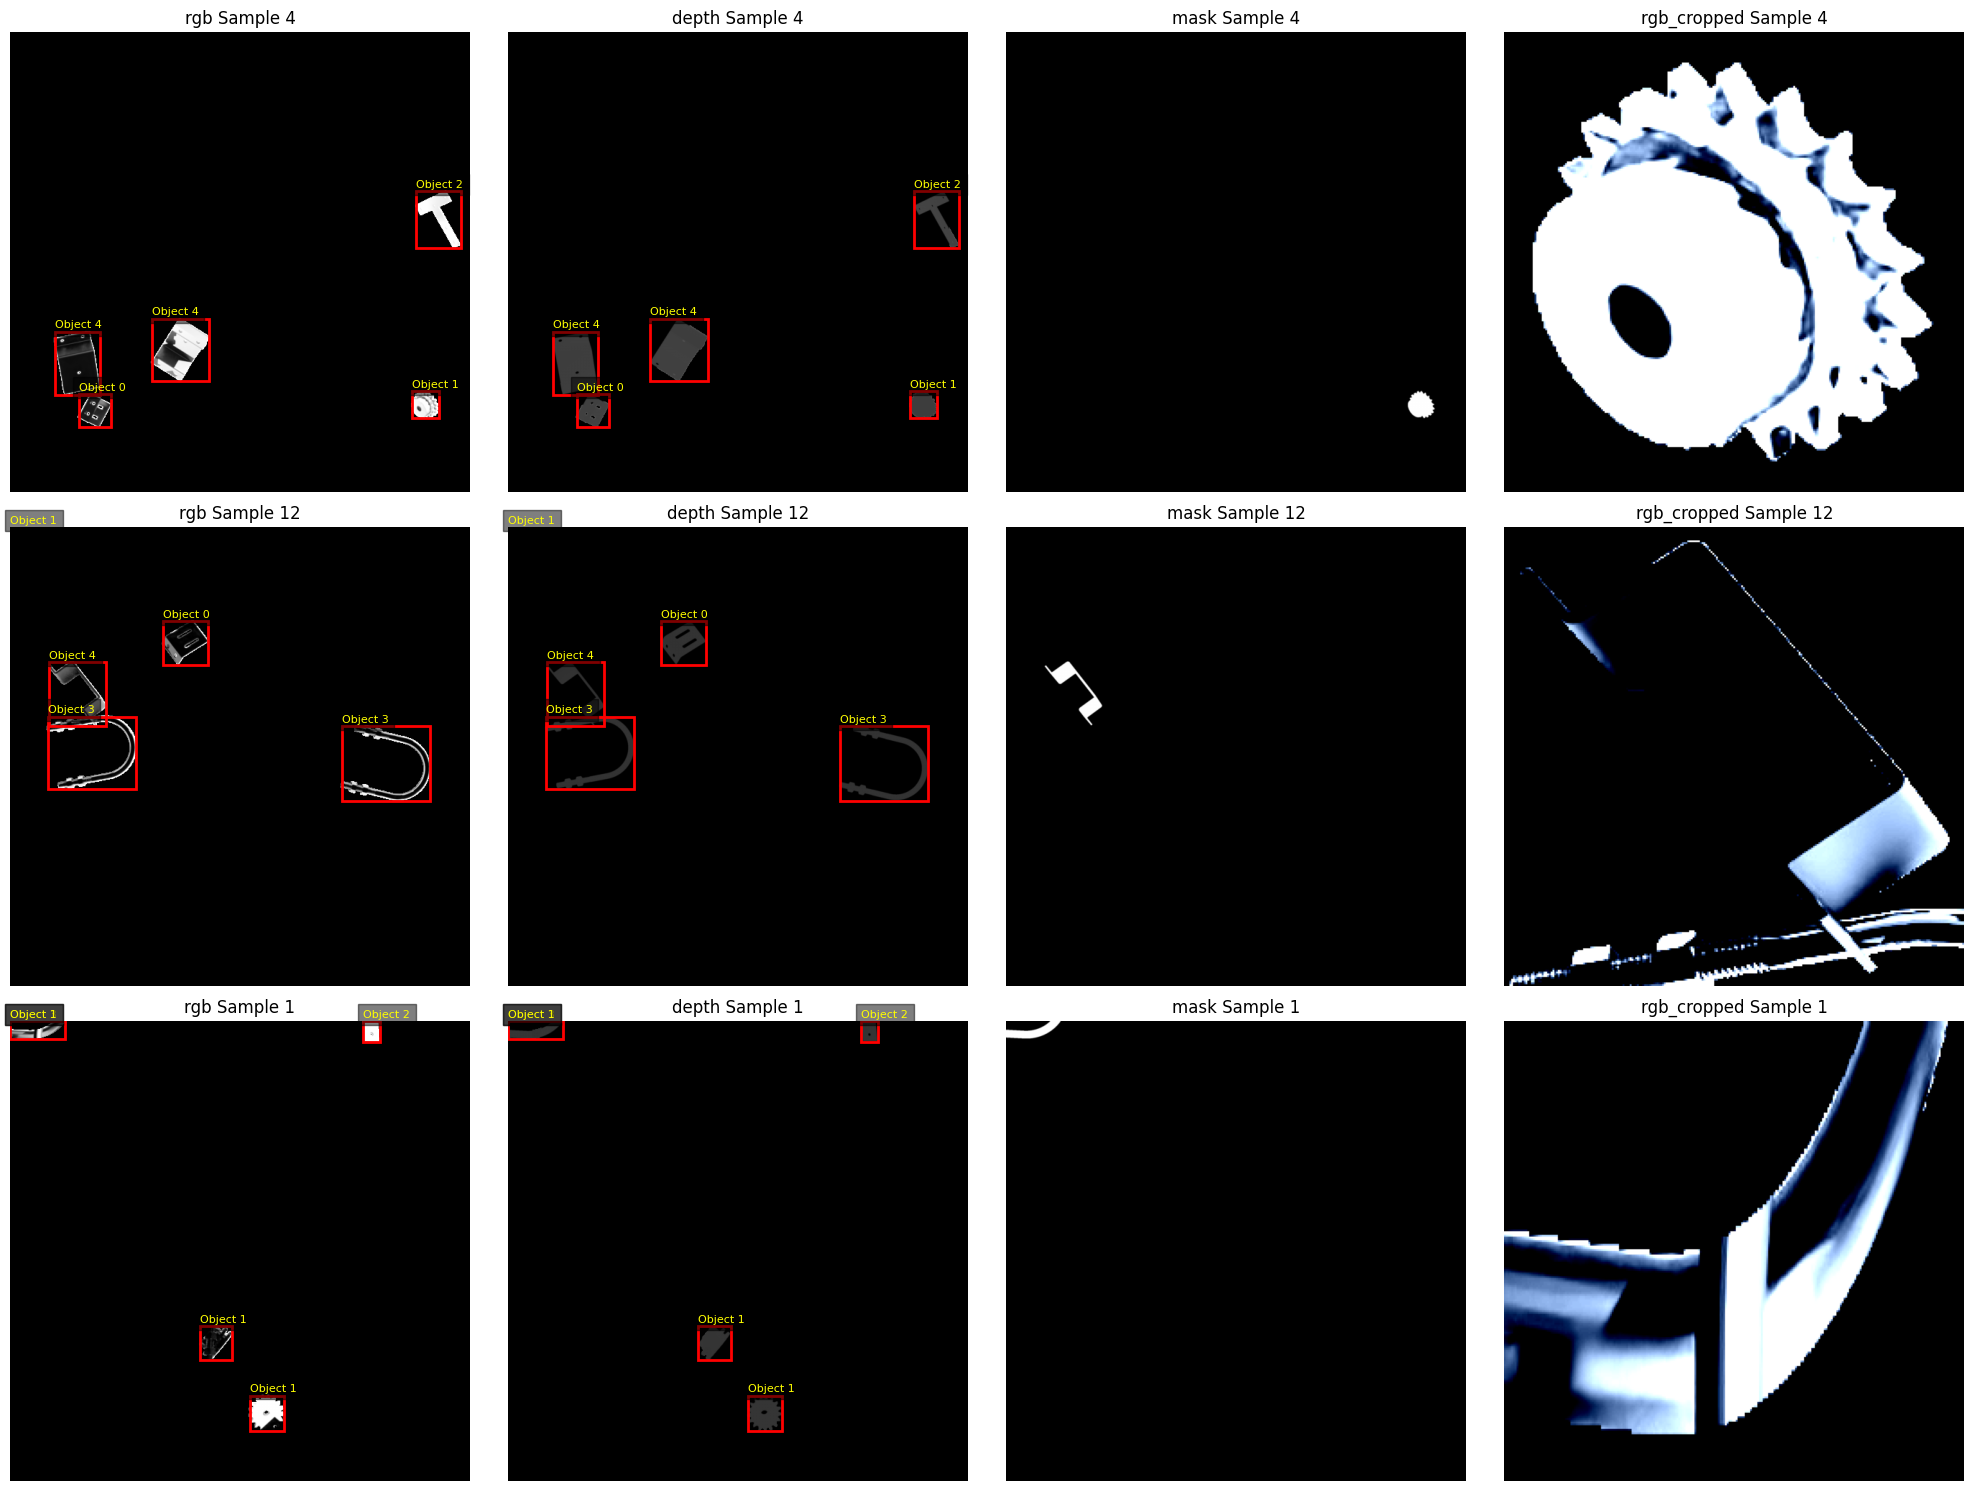

In [10]:
num_images = 3
plot_sample_images(train_loader,image_type, num_images)

##### Validation dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7859696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.8044444].


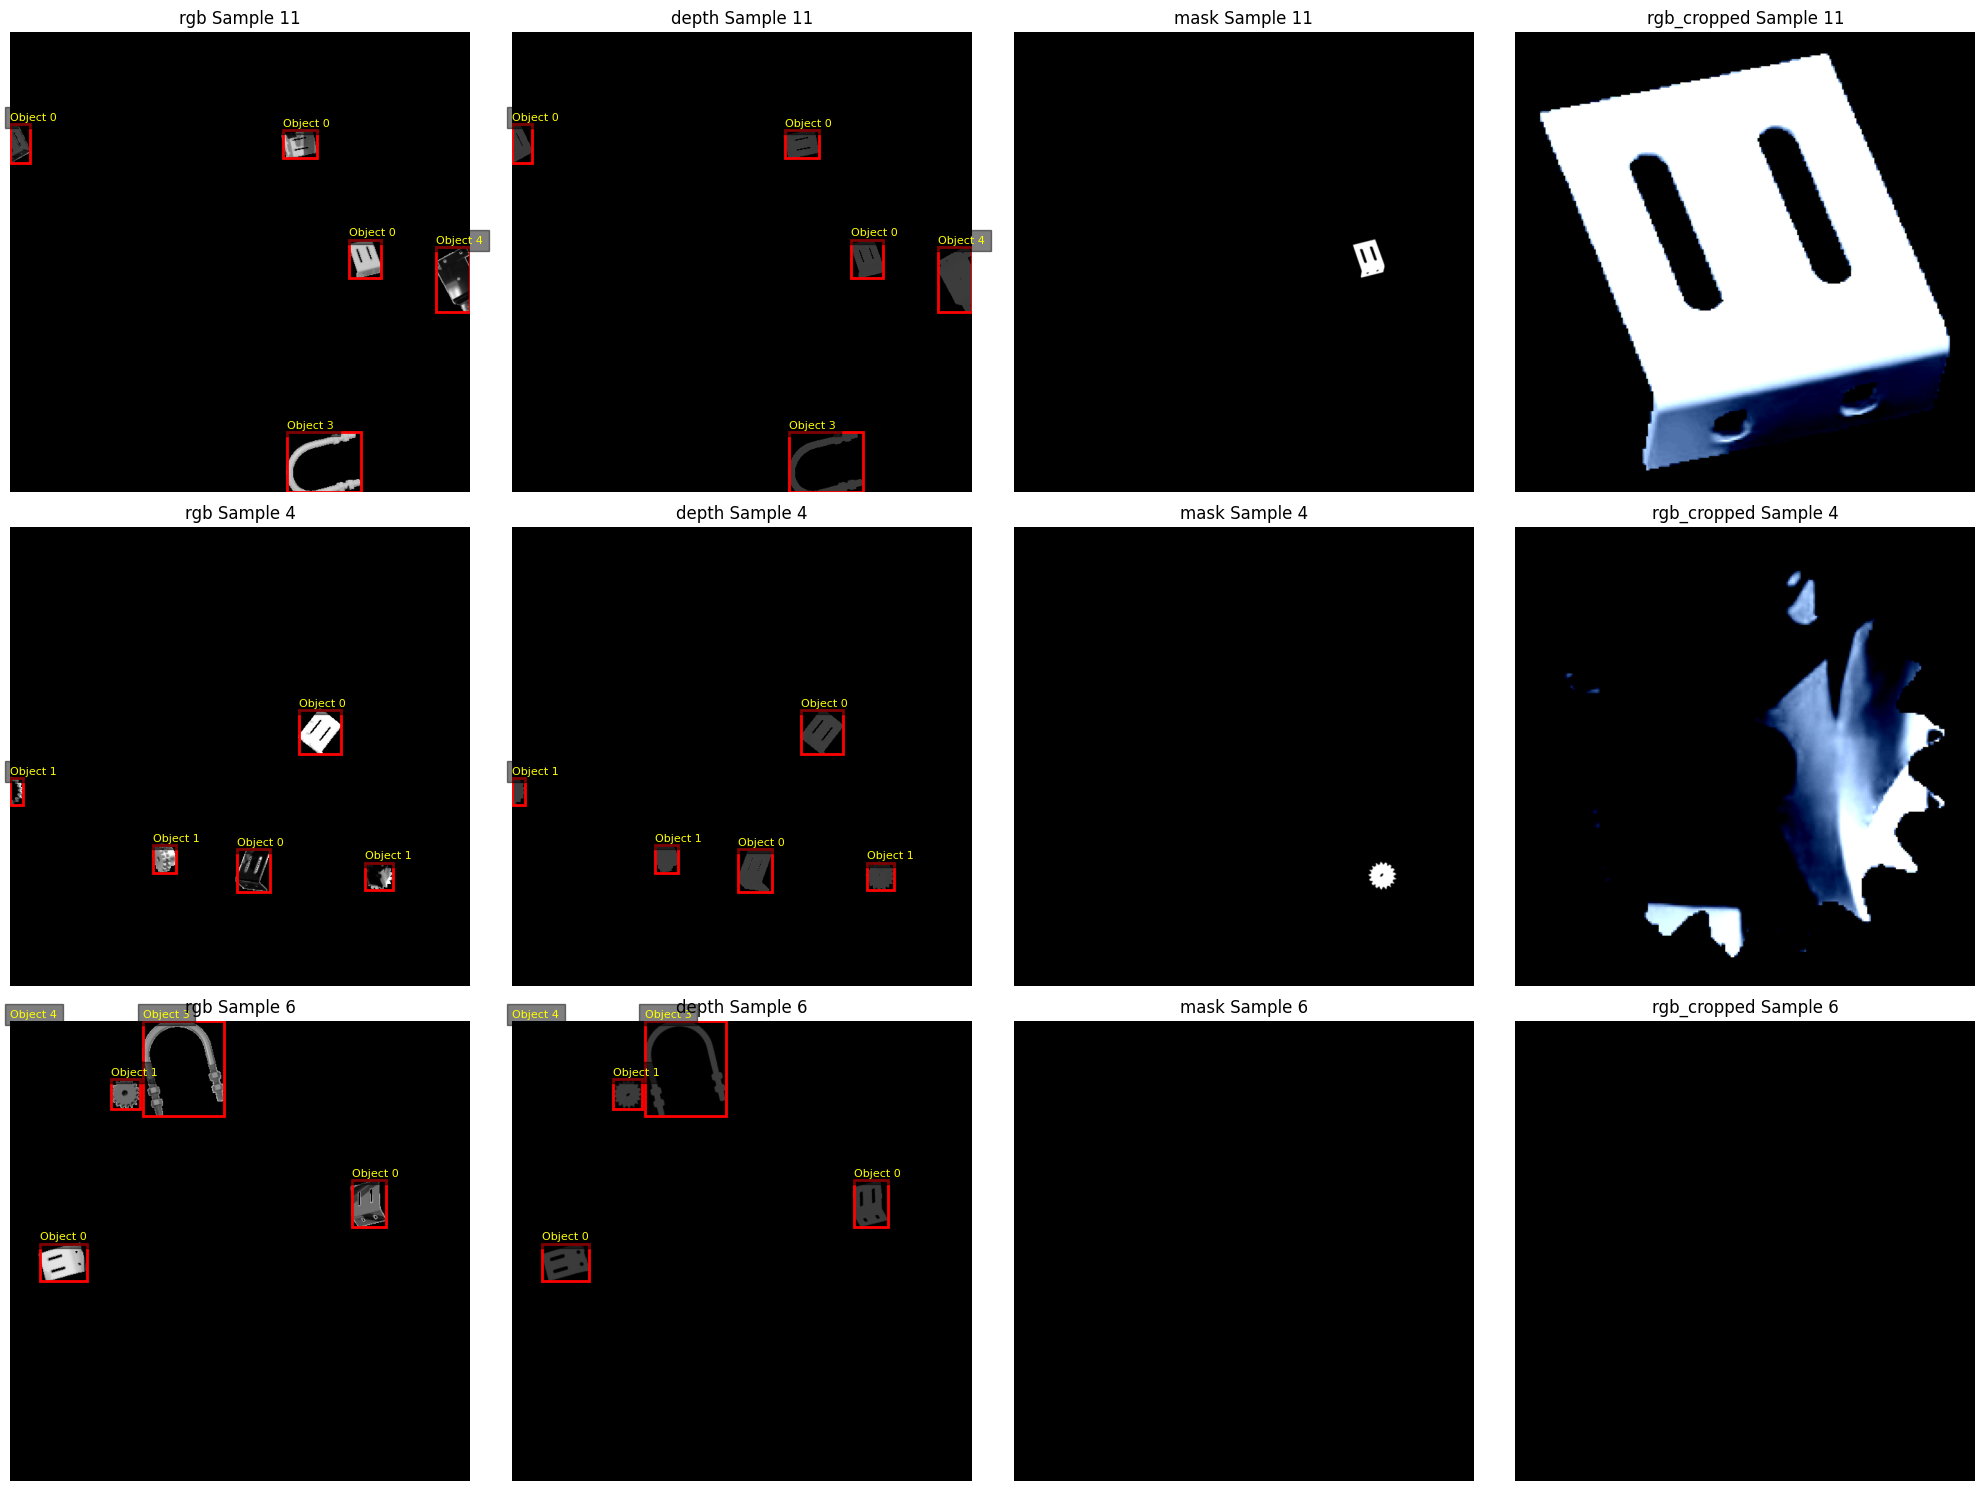

In [11]:
num_images = 3
plot_sample_images(val_loader,image_type, num_images)

##### Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.44392177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.6007845].


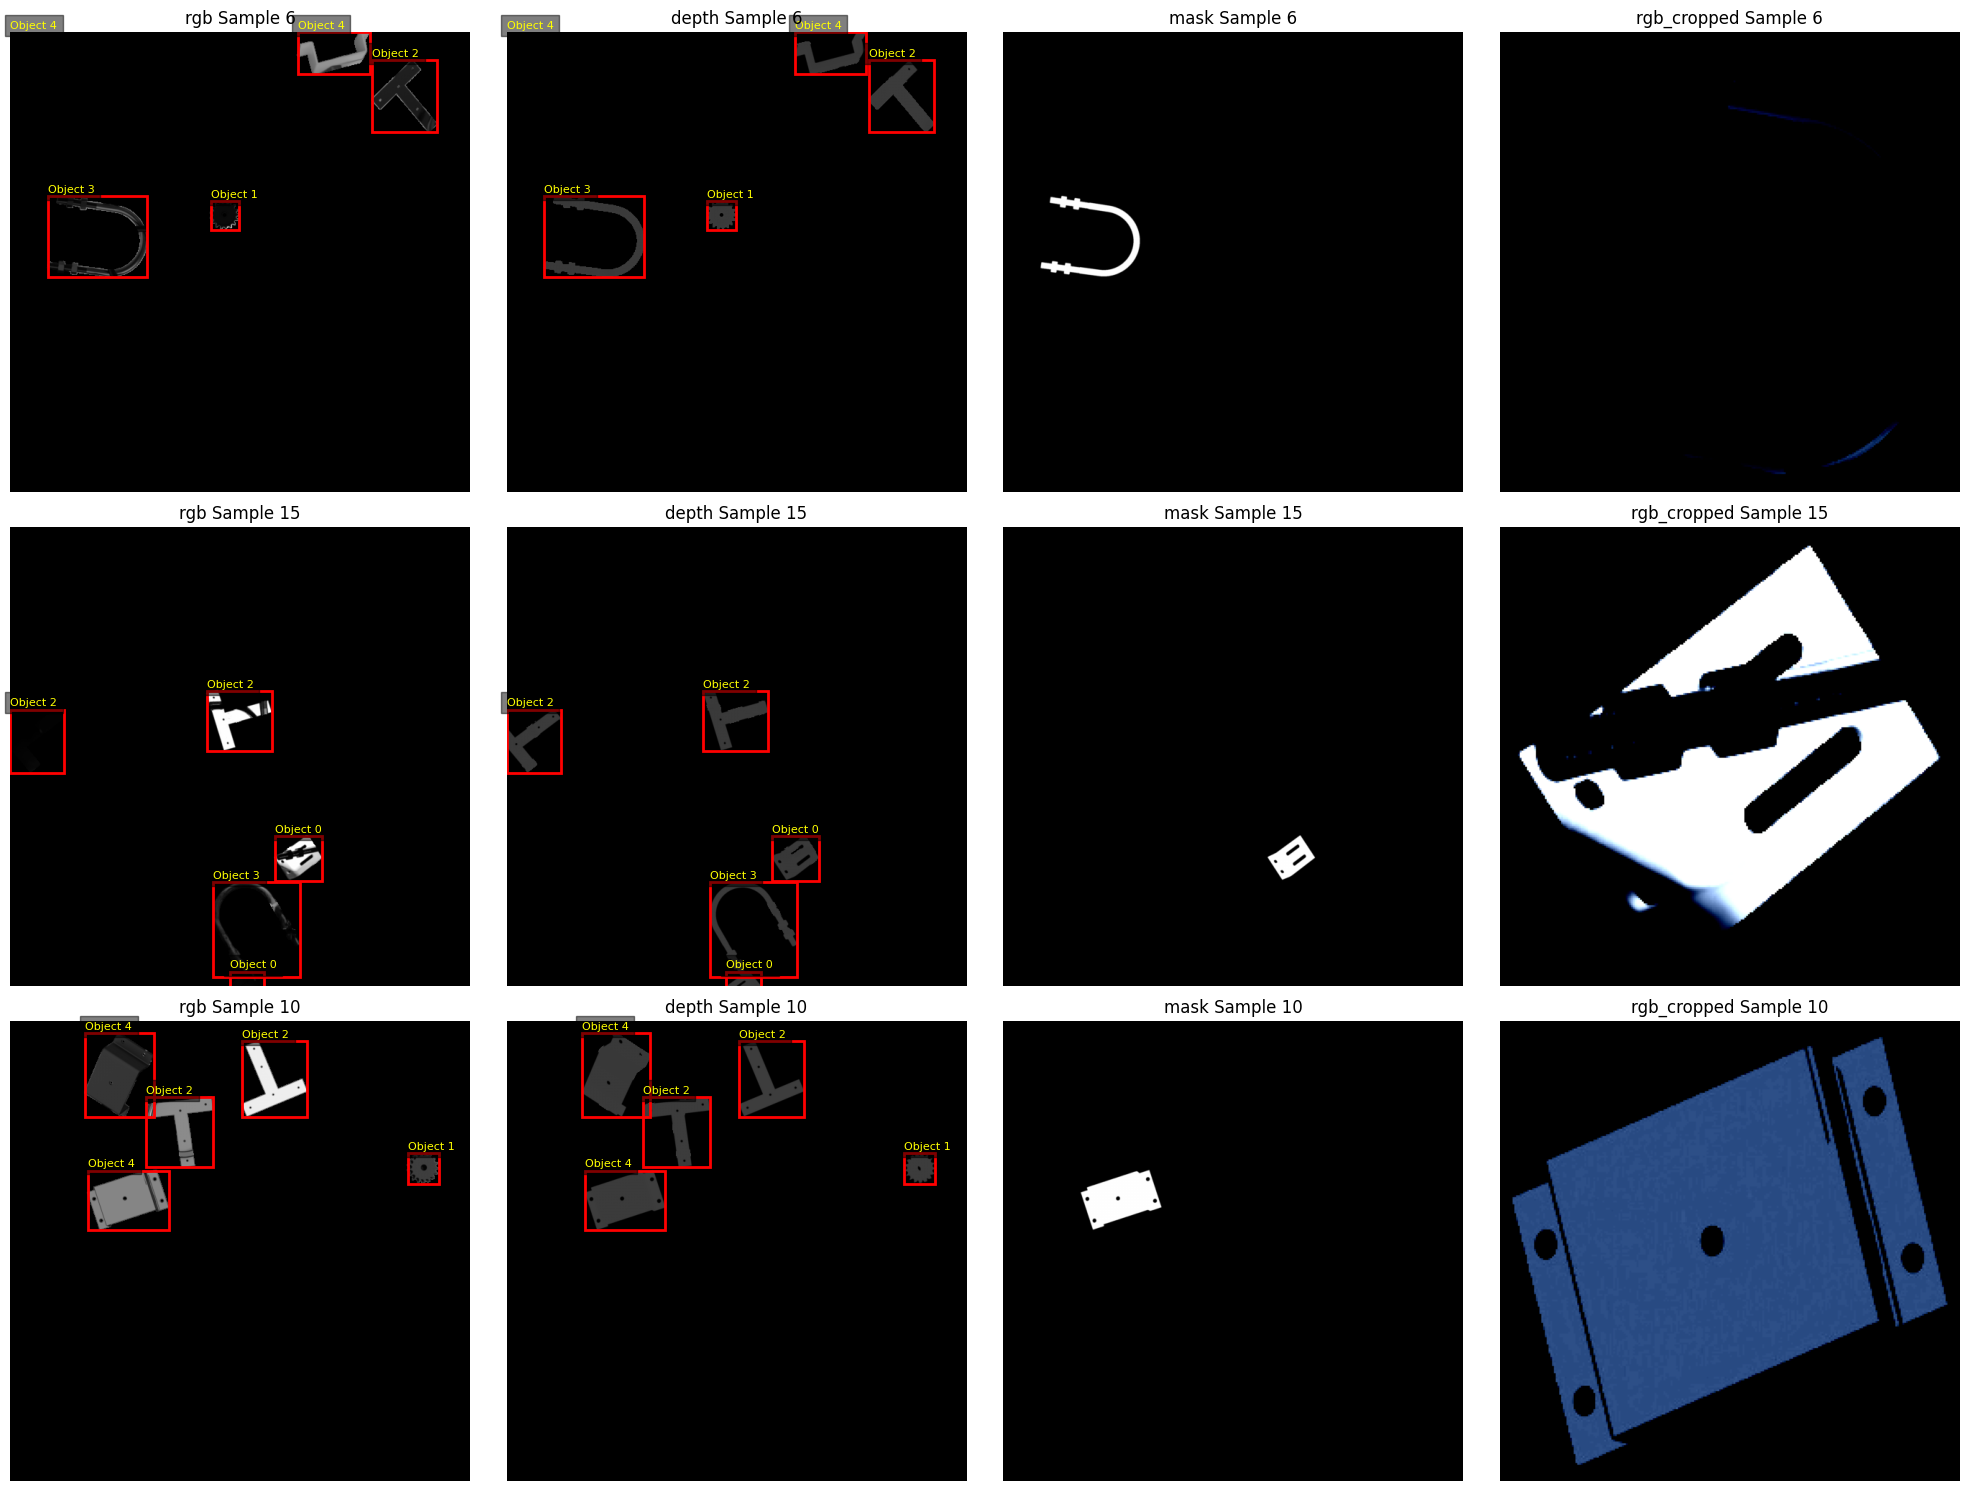

In [12]:
num_images = 3
plot_sample_images(test_loader,image_type, num_images)

### 3. Training for B Box

In [5]:
from ultralytics import YOLO
from ultralytics.models.yolo.model import Model
from ultralytics.nn.modules.conv import Concat
from ultralytics.nn.tasks import attempt_load_one_weight
from ultralytics.nn.modules.head import Detect
from ultralytics.utils.loss import v8DetectionLoss  # or E2EDetectLoss
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.ops import nms
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
from copy import deepcopy
import cv2
from types import SimpleNamespace
import math
import os

In [6]:
class fused_bbox_model(nn.Module):
    def __init__(self, backbone_cfg='yolo11n.yaml',nc=10):
        super().__init__()

        full_model = YOLO(backbone_cfg).model

        full = YOLO("yolo11-detection-obj_0.pt").model
        # full = YOLO("ckpt_epoch40.pt")
        
        orig_detect = full.model[-1]
        
        rgb_layers = list(full_model.model)
        depth_layers = deepcopy(rgb_layers)

        
        # Backbone
        self.rgb_early = nn.Sequential(*rgb_layers[:3])
        self.depth_early = nn.Sequential(*depth_layers[:3])

        self.fusion_layer = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=0.001, momentum=0.03),
            nn.SiLU(inplace=True)
        )
    
        self.early_backbone = nn.Sequential(*rgb_layers[3:5]) # concat this with concat 2
        self.mid_backbone = nn.Sequential(*rgb_layers[5:7]) # concat this with concat 1
        self.late_backbone = nn.Sequential(*rgb_layers[7:9])

        # Neck
        self.neck = nn.Sequential(*rgb_layers[9:11]) # concat this with concat 4

        self.upsample1 = rgb_layers[11]
        
        self.concat1 = rgb_layers[12] # merge  upsample1 with mid_backbone
        
        self.c3k2_1 = rgb_layers[13] # concat this with concat 3
        self.upsample2 = rgb_layers[14]
        
        self.concat2 = rgb_layers[15] # merge upsample2 with early_backbone

        self.c3k2_2 = rgb_layers[16] # output of 80 x 80 ?
        
        self.conv1 = rgb_layers[17]
        
        self.concat3 = rgb_layers[18] # merge conv1 with c3k2_1

        self.c3k2_3 = rgb_layers[19] # output of 40 x 40 ?
        
        self.conv2 = rgb_layers[20] # concat with concat 4

        self.concat4 = rgb_layers[21] # metge conv2 with neck

        self.c3k2_4 = rgb_layers[22] # output of 20 x 20 ?


        # Head
        ch = [self.c3k2_2.cv2.conv.out_channels,
                  self.c3k2_3.cv2.conv.out_channels,
                  self.c3k2_4.cv2.conv.out_channels]
        self.head = Detect(nc=nc, ch=ch)

        self.head.anchors     = orig_detect.anchors
        self.head.stride      = orig_detect.stride




    def forward(self, inputs):
        rgb = inputs['rgb']
        depth = inputs['depth']

        # Fusion backbone
        rgb_feat = self.rgb_early(rgb)
        depth_feat = self.depth_early(depth)

        fused = torch.cat([rgb_feat, depth_feat], dim=1)
        fused = self.fusion_layer(fused)
        
        x1 = self.early_backbone(fused)

        x2 = self.mid_backbone(x1)

        x3 = self.late_backbone(x2)
        
        # Neck

        x4 = self.neck(x3)

        x5 = self.concat1([self.upsample1(x4), x2])

        x6 = self.c3k2_1(x5)

        x7 = self.concat2([self.upsample2(x6),x1])

        x8 = self.c3k2_2(x7) # 80 x 80

        x9 = self.concat3([self.conv1(x8),x6])

        x10 = self.c3k2_3(x9) # 40 x 40

        x11 = self.concat4([self.conv2(x10),x4]) 

        x12 = self.c3k2_4(x11) # 20 x 20

        # head
        return self.head([x8, x10, x12])

In [7]:
class YOLO11Loss(nn.Module):
    def __init__(self,
                 reg_max: int,
                 num_classes: int,
                 λ_cls: float = 1.0,
                 λ_dfl: float = 1.0,
                 λ_ciou: float = 3.0,
                 eps: float = 1e-8):
        """
        reg_max: number of distribution bins per side
        num_classes: number of object classes
        λ_cls, λ_dfl, λ_ciou: loss weights
        eps: small constant to prevent div/0 and log(0)
        """
        super().__init__()
        self.reg_max     = reg_max
        self.num_classes = num_classes
        self.λ_cls       = λ_cls
        self.λ_dfl       = λ_dfl
        self.λ_ciou      = λ_ciou
        self.eps         = eps

        self.bce = nn.BCEWithLogitsLoss(reduction='sum')

    def forward(self, preds, targets):

        B, _, H, W = preds.shape
        rm = self.reg_max
        C  = self.num_classes

        # split into class logits and reg preds
        cls_logits = preds[:, :C, :, :]                          # (B,C,H,W)
        reg_preds   = preds[:, C:, :, :].view(B, 4, rm, H, W)    # (B,4,rm,H,W)
        reg_prob    = F.softmax(reg_preds, dim=2).clamp(min=self.eps, max=1.0)

        loss_cls  = 0.0
        loss_dfl  = 0.0
        loss_ciou = 0.0

        for b in range(B):
            t = targets[b]
            if t.numel() == 0:
                continue

            # compute grid indices
            gx = (t[:,1] * W).clamp(0, W-1)
            gy = (t[:,2] * H).clamp(0, H-1)
            gi = gx.long()
            gj = gy.long()

            # ---- classification loss ----
            # one-hot
            cls_t = torch.zeros((t.shape[0], C), device=preds.device)
            cls_t[torch.arange(t.shape[0]), t[:,0].long()] = 1.0
            p_logits = cls_logits[b, :, gj, gi].permute(1,0)  # (Ni,C)
            loss_cls += self.bce(p_logits, cls_t)

            # prepare true box coords
            cx = (gi.float() + 0.5) / W
            cy = (gj.float() + 0.5) / H
            half_wh = t[:,3:5] * 0.5
            x1 = t[:,1] - half_wh[:,0]
            y1 = t[:,2] - half_wh[:,1]
            x2 = t[:,1] + half_wh[:,0]
            y2 = t[:,2] + half_wh[:,1]

            # true distances in grid units
            dl = ((cx - x1) * W).clamp(0, rm-1)
            dt = ((cy - y1) * H).clamp(0, rm-1)
            dr = ((x2 - cx) * W).clamp(0, rm-1)
            db = ((y2 - cy) * H).clamp(0, rm-1)
            true_dists = torch.stack([dl, dt, dr, db], dim=1)  # (Ni,4)

            # ---- Distribution Focal Loss (DFL) ----
            for side in range(4):
                pd = reg_prob[b, side, :, gj, gi].permute(1,0)  # (Ni,rm)
                td = true_dists[:, side]
                l  = td.floor().long()
                u  = (l + 1).clamp(max=rm-1)
                w  = (td - l.float()).clamp(0,1)

                # soft target dist
                dist_t = torch.zeros_like(pd)
                dist_t[range(td.size(0)), l] += (1 - w)
                dist_t[range(td.size(0)), u] += w

                loss_dfl += - (dist_t * torch.log(pd + self.eps)).sum()

            # ---- CIoU Loss ----
            # decode pred distances by expectation
            exp_i = torch.arange(rm, device=preds.device).view(1,rm)
            pdist = reg_prob[b, :, :, gj, gi].permute(2,0,1)  # (Ni,4,rm)
            est_d = (pdist * exp_i).sum(dim=2)                # (Ni,4)

            # predicted box corners
            px1 = cx - est_d[:,0:1]/W
            py1 = cy - est_d[:,1:2]/H
            px2 = cx + est_d[:,2:3]/W
            py2 = cy + est_d[:,3:4]/H
            pb = torch.cat([px1,py1,px2,py2], dim=1)         # (Ni,4)
            tb = torch.stack([x1,y1,x2,y2], dim=1)           # (Ni,4)

            # clamp widths/heights
            w_pred = (pb[:,2] - pb[:,0]).clamp(min=self.eps)
            h_pred = (pb[:,3] - pb[:,1]).clamp(min=self.eps)
            w_true = (tb[:,2] - tb[:,0]).clamp(min=self.eps)
            h_true = (tb[:,3] - tb[:,1]).clamp(min=self.eps)

            # intersection
            ix1 = torch.max(pb[:,0], tb[:,0])
            iy1 = torch.max(pb[:,1], tb[:,1])
            ix2 = torch.min(pb[:,2], tb[:,2])
            iy2 = torch.min(pb[:,3], tb[:,3])
            inter = (ix2 - ix1).clamp(0) * (iy2 - iy1).clamp(0)

            # union & IoU
            ap = w_pred * h_pred
            at = w_true * h_true
            union = ap + at - inter
            iou = inter / union.clamp(min=self.eps)

            # center distance
            pcx = (pb[:,0] + pb[:,2]) * 0.5
            pcy = (pb[:,1] + pb[:,3]) * 0.5
            tcx = (tb[:,0] + tb[:,2]) * 0.5
            tcy = (tb[:,1] + tb[:,3]) * 0.5
            # enclosing diag
            cx1e = torch.min(pb[:,0], tb[:,0])
            cy1e = torch.min(pb[:,1], tb[:,1])
            cx2e = torch.max(pb[:,2], tb[:,2])
            cy2e = torch.max(pb[:,3], tb[:,3])
            c2 = ((cx2e - cx1e)**2 + (cy2e - cy1e)**2).clamp(min=self.eps)

            # aspect ratio penalty
            v = (4 / math.pi**2) * (torch.atan(w_true / h_true) - torch.atan(w_pred / h_pred)).pow(2)
            alpha = v / (1 - iou + v + self.eps)

            loss_ciou += ((1 - iou) + alpha * v).sum()

        total = (self.λ_cls  * loss_cls +
                 self.λ_dfl  * loss_dfl +
                 self.λ_ciou * loss_ciou) / B
        return total


In [8]:
import torch
import torch.nn.functional as F
from torchvision.ops import nms

def decode_and_nms(preds_raw, reg_max, num_classes,
                   conf_thres=0.001, iou_thres=0.6):
    """
    preds_raw: list of 3 tensors, each (B, 4*reg_max + C, H, W)
    returns: list of B dicts: {"boxes": Tensor[n,4], "scores":Tensor[n], "labels":Tensor[n]}
    """
    device = preds_raw[0].device
    B = preds_raw[0].shape[0]
    rm, C = reg_max, num_classes

    batch_out = []
    for b in range(B):
        all_boxes  = []
        all_scores = []
        all_labels = []
        # loop over scales
        for pred in preds_raw:
            _, _, H, W = pred.shape
            # split
            cls_logits = pred[b, :C, :, :]                      # (C,H,W)
            reg_preds   = pred[b, C:, :, :].view(4, rm, H, W)    # (4,rm,H,W)

            # class probabilities
            cls_prob = torch.sigmoid(cls_logits)

            # turn distribution → continuous distance
            reg_prob = F.softmax(reg_preds, dim=1)               # (4,rm,H,W)
            exp_i    = torch.arange(rm, device=device).view(1,rm,1,1)
            dists    = (reg_prob * exp_i).sum(dim=1)             # (4,H,W)

            # grid centers in [0,1]
            ys, xs = torch.meshgrid(torch.arange(H,device=device),
                                    torch.arange(W,device=device),
                                    indexing='ij')
            cx = (xs.float() + 0.5) / W
            cy = (ys.float() + 0.5) / H

            # compute corners
            l = dists[0]; t = dists[1]; r = dists[2]; b_ = dists[3]
            x1 = (cx - l / H).clamp(0,1)
            y1 = (cy - t / H).clamp(0,1)
            x2 = (cx + r / H).clamp(0,1)
            y2 = (cy + b_ / H).clamp(0,1)

            # for each class, threshold & collect
            for cls_id in range(C):
                scores = cls_prob[cls_id]                    # (H,W)
                mask   = scores > conf_thres
                if not mask.any(): 
                    continue
                # flatten indices
                ys_m, xs_m = ys[mask], xs[mask]
                boxes = torch.stack([
                    x1[mask], y1[mask],
                    x2[mask], y2[mask]
                ], dim=1)                                    # (n,4)
                scs   = scores[mask]                         # (n,)
                labs  = torch.full_like(scs, cls_id, dtype=torch.long)
                all_boxes.append(boxes)
                all_scores.append(scs)
                all_labels.append(labs)

        if len(all_boxes):
            boxes  = torch.cat(all_boxes, dim=0)
            scores = torch.cat(all_scores)
            labels = torch.cat(all_labels)
            keep   = nms(boxes, scores, iou_thres)
            batch_out.append({
                "boxes":  boxes[keep],
                "scores": scores[keep],
                "labels": labels[keep],
            })
        else:
            batch_out.append({
                "boxes":  torch.empty((0,4), device=device),
                "scores": torch.empty((0,), device=device),
                "labels": torch.empty((0,), dtype=torch.long, device=device),
            })

    return batch_out


In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
os.makedirs("checkpoints", exist_ok=True)

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net       = fused_bbox_model(nc=10).to(device)
criterion = YOLO11Loss(reg_max=16, num_classes=10).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

use_mask = False
# Load checkpoint if required
ckpt = torch.load("ckpt_epoch25.pt")
net.load_state_dict(ckpt["model_state_dict"])
# prepare mAP metric
map_metric = MeanAveragePrecision().to(device)

total_train_loss = []
total_val_loss = []

num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1.0/num_epochs))

In [11]:
pretrained = YOLO("yolo11-detection-obj_0.pt").model
orig_layers = list(pretrained.model)   


for i, layer in enumerate(orig_layers[:-1]):  
    sd = layer.state_dict()

    if i < 3:  
        net.rgb_early[i].load_state_dict(sd)
        net.depth_early[i].load_state_dict(sd)
    elif i < 5:  
        net.early_backbone[i-3].load_state_dict(sd)
    elif i < 7:  
        net.mid_backbone[i-5].load_state_dict(sd)
    elif i < 9:  
        net.late_backbone[i-7].load_state_dict(sd)
    elif i < 11: 
        net.neck[i-9].load_state_dict(sd)
    elif i == 11:
        net.upsample1.load_state_dict(sd)
    elif i == 12:
        net.concat1.load_state_dict(sd)
    elif i == 13:
        net.c3k2_1.load_state_dict(sd)
    elif i == 14:
        net.upsample2.load_state_dict(sd)
    elif i == 15:
        net.concat2.load_state_dict(sd)
    elif i == 16:
        net.c3k2_2.load_state_dict(sd)
    elif i == 17:
        net.conv1.load_state_dict(sd)
    elif i == 18:
        net.concat3.load_state_dict(sd)
    elif i == 19:
        net.c3k2_3.load_state_dict(sd)
    elif i == 20:
        net.conv2.load_state_dict(sd)
    elif i == 21:
        net.concat4.load_state_dict(sd)
    elif i == 22:
        net.c3k2_4.load_state_dict(sd)


print("Pretrained weights loaded into fusion model")


Pretrained weights loaded into fusion model


In [12]:
for epoch in range(num_epochs):
    # ——— training —————————————————————————————————————————————————————
    net.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for images, targets, _, _,_ in tqdm(train_loader):

        
        tars = [t.to(device) for t in targets]

        imgs = {}                               
        for k in ["rgb","depth"]:              
            modality_tensors = []
            for i,img in enumerate(images):
                modality_tensors.append(img[k])
    
            
            batched = torch.stack(modality_tensors)
            imgs[k] = batched.to(device)

        optimizer.zero_grad()
        train_preds = net(imgs)              
        
        loss = sum(criterion(p, tars) for p in train_preds) / len(train_preds)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f" → Train loss: {avg_loss:.4f}")
    total_train_loss.append(avg_loss)

    # … after training loop …
    if ((epoch + 1) % 5 == 0) or (epoch == 0):
        net.eval()
        val_loss = 0.0
        map_metric.reset()
        
        with torch.no_grad():
            for images, targets,_,_,_ in tqdm(val_loader):

                tars = [t.to(device) for t in targets]
                imgs = {}           
                
                for k in ["rgb","depth"]:              
                    modality_tensors = []
                    for i,img in enumerate(images):
                        modality_tensors.append(img[k])
                    batched = torch.stack(modality_tensors)
                    imgs[k] = batched.to(device)
                
        
                # Forward pass
                val_preds = net(imgs)  # list of 3 raw-scale tensors
                raw_preds = val_preds[1]
                # Compute loss across scales
                loss_batch = sum(criterion(p, tars) for p in raw_preds) / len(raw_preds)
                val_loss  += loss_batch.item()
        
        
                # — build GT dicts for this batch —
                gts = []
                for t in targets:
                    xc, yc, w, h = t[:,1], t[:,2], t[:,3], t[:,4]
                    x1 = xc - 0.5*w; y1 = yc - 0.5*h
                    x2 = xc + 0.5*w; y2 = yc + 0.5*h
                    gts.append({
                        "boxes":  torch.stack([x1,y1,x2,y2], dim=1).to(device),
                        "labels": t[:,0].long().to(device),
                    })
        
                # — decode + NMS to get prediction dicts —
                preds = decode_and_nms(
                    raw_preds,
                    reg_max=16,
                    num_classes=10,
                    conf_thres=0.001,
                    iou_thres=0.6
                )
        
                # — update mAP metric —
                map_metric.update(preds, gts)
    
        # — after all val batches —
        avg_val_loss = val_loss / len(val_loader)
        mAP_res      = map_metric.compute()
        print(f" → Val loss: {avg_val_loss:.4f} | "
              f"mAP@.50:.95 = {mAP_res['map'].item():.4f}, "
              f"mAP@.50 = {mAP_res['map_50'].item():.4f}")
        total_val_loss.append(avg_loss)
        # ——— checkpoint every 5 epochs —————————————————————————————————————
    
        ckpt = {
            "epoch": epoch + 1,
            "model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": avg_loss,
            "val_loss": avg_val_loss,
            "mAP_50_95": mAP_res["map"].item(),
            "mAP_50": mAP_res["map_50"].item(),
        }
        path = f"checkpoints/ckpt_epoch{epoch+1}.pt"
        torch.save(ckpt, path)
        print(f"  Saved checkpoint: {path}")
    scheduler.step()

Epoch 1/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:58<00:00, 12.55s/it]


 → Train loss: 51.7262


/home/vikramraj/anaconda3/envs/cs444/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████| 19/19 [05:38<00:00, 17.79s/it]


 → Val loss: 89.6771 | mAP@.50:.95 = 0.0028, mAP@.50 = 0.0140
  Saved checkpoint: checkpoints/ckpt_epoch1.pt
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.79s/it]


 → Train loss: 42.1567
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:01<00:00,  9.57s/it]


 → Train loss: 39.5976
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:02<00:00,  9.60s/it]


 → Train loss: 38.4276
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.76s/it]


 → Train loss: 36.9401


100%|████████████████████████████████████████████████████████████████████| 19/19 [04:46<00:00, 15.06s/it]


 → Val loss: 38.4313 | mAP@.50:.95 = 0.2710, mAP@.50 = 0.5065
  Saved checkpoint: checkpoints/ckpt_epoch5.pt
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:01<00:00,  9.55s/it]


 → Train loss: 36.1786
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:02<00:00,  9.63s/it]


 → Train loss: 35.6023
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:03<00:00,  9.65s/it]


 → Train loss: 35.1454
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:04<00:00,  9.72s/it]


 → Train loss: 34.8913
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:04<00:00,  9.70s/it]


 → Train loss: 34.5175


100%|████████████████████████████████████████████████████████████████████| 19/19 [04:51<00:00, 15.36s/it]


 → Val loss: 35.0916 | mAP@.50:.95 = 0.3626, mAP@.50 = 0.6180
  Saved checkpoint: checkpoints/ckpt_epoch10.pt
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.75s/it]


 → Train loss: 33.9510
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:07<00:00,  9.88s/it]


 → Train loss: 33.7795
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.74s/it]


 → Train loss: 33.6846
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:03<00:00,  9.67s/it]


 → Train loss: 33.2665
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:01<00:00,  9.55s/it]


 → Train loss: 32.9623


100%|████████████████████████████████████████████████████████████████████| 19/19 [04:44<00:00, 14.97s/it]


 → Val loss: 33.7044 | mAP@.50:.95 = 0.4063, mAP@.50 = 0.6441
  Saved checkpoint: checkpoints/ckpt_epoch15.pt
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:00<00:00,  9.49s/it]


 → Train loss: 32.8175
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.74s/it]


 → Train loss: 32.7046
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:00<00:00,  9.51s/it]


 → Train loss: 32.5333
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:02<00:00,  9.63s/it]


 → Train loss: 32.5725
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:05<00:00,  9.76s/it]


 → Train loss: 32.2866


100%|████████████████████████████████████████████████████████████████████| 19/19 [04:46<00:00, 15.10s/it]


 → Val loss: 33.2999 | mAP@.50:.95 = 0.4110, mAP@.50 = 0.6596
  Saved checkpoint: checkpoints/ckpt_epoch20.pt
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:00<00:00,  9.48s/it]


 → Train loss: 31.8723
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:02<00:00,  9.60s/it]


 → Train loss: 31.9846
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:03<00:00,  9.68s/it]


 → Train loss: 31.9265
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:07<00:00,  9.89s/it]


 → Train loss: 31.9022
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████| 19/19 [03:04<00:00,  9.70s/it]


 → Train loss: 31.7027


100%|████████████████████████████████████████████████████████████████████| 19/19 [04:48<00:00, 15.18s/it]


 → Val loss: 32.7401 | mAP@.50:.95 = 0.4210, mAP@.50 = 0.6648
  Saved checkpoint: checkpoints/ckpt_epoch25.pt
Epoch 26/100


 68%|██████████████████████████████████████████████▌                     | 13/19 [02:16<01:02, 10.49s/it]


KeyboardInterrupt: 

### Loss and mAP plots

In [16]:
checkpoint_dir = "./checkpoints/working"
epochs = []
train_losses = []
val_losses = []
map_50_95 = []
map_50 = []

# Make sure files are sorted by epoch number
# print(os.listdir(checkpoint_dir))
files = sorted(os.listdir(checkpoint_dir), key=lambda x: int(x.split("_epoch")[1].split(".")[0]))

for file in files:
    if file.endswith(".pt"):
        path = os.path.join(checkpoint_dir, file)
        ckpt = torch.load(path, map_location='cpu')
        
        epochs.append(ckpt["epoch"])
        train_losses.append(ckpt["train_loss"])
        val_losses.append(ckpt["val_loss"])
        map_50_95.append(ckpt["mAP_50_95"])
        map_50.append(ckpt["mAP_50"])


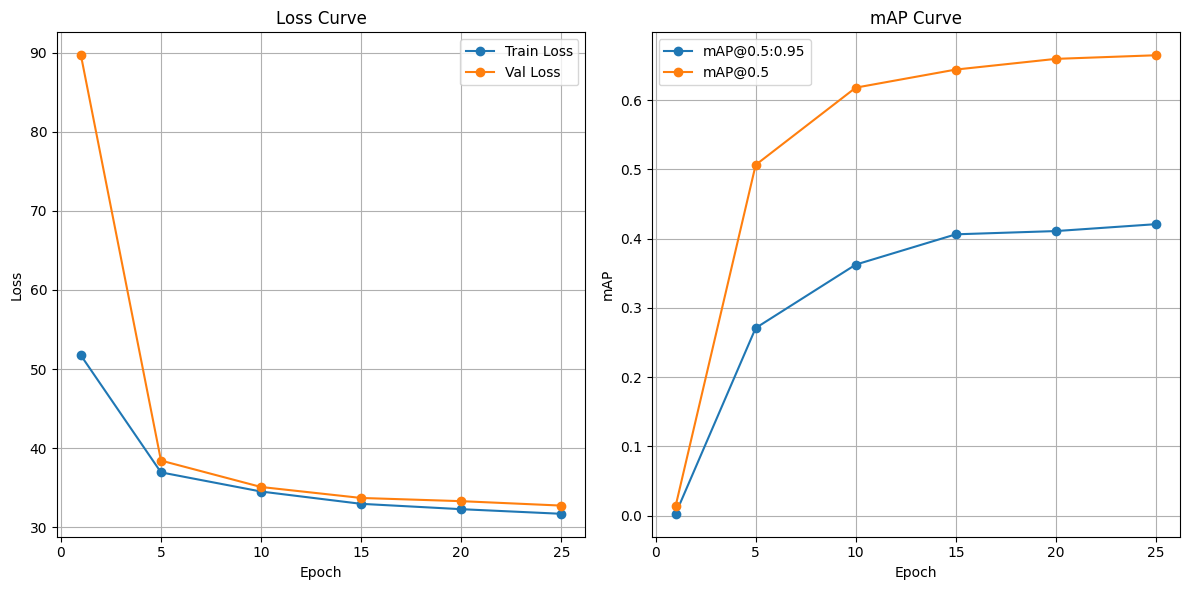

In [18]:
# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plot mAP
plt.subplot(1, 2, 2)
plt.plot(epochs, map_50_95, marker='o', label='mAP@0.5:0.95')
plt.plot(epochs, map_50, marker='o', label='mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Testing on test dataset

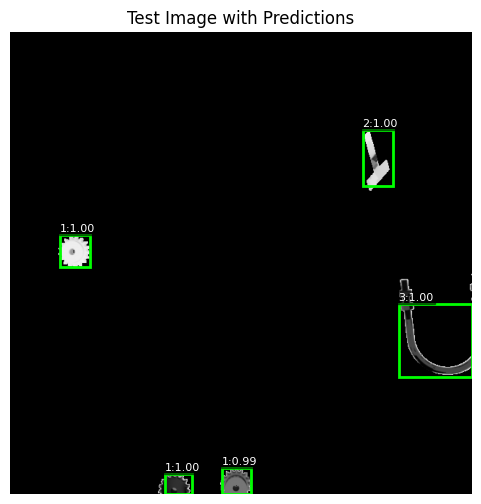

In [13]:
images_batch, targets_batch, _, _,_ = next(iter(test_loader))
batch_size = len(images_batch)
idx = random.randint(0, batch_size - 1)
sample = images_batch[idx]
# make a batch of size 1
imgs = {
    k: sample[k].unsqueeze(0).to(device)   
    for k in ["rgb", "depth"]
}

net.eval()
with torch.no_grad():
    preds = net(imgs)            # list of 3 scales
    raw = preds[1]               # pick the middle scale (as in val code)


pred_dicts = decode_and_nms(
    raw,
    reg_max=16,
    num_classes=10,
    conf_thres=0.9,
    iou_thres=0.2
)

preds0 = pred_dicts[0]

img_tensor = sample["rgb"]            # shape (3, H, W)
img_np = img_tensor.permute(1, 2, 0)  # (H, W, 3)
img_np = img_np.cpu().numpy()         # numpy array
H, W, _ = img_np.shape


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img_np)
ax.set_title("Test Image with Predictions")
ax.axis("off")

for box, score, cls in zip(preds0["boxes"], preds0["scores"], preds0["labels"]):
    x1, y1, x2, y2 = box.tolist()
    # convert to pixel coords
    x1 *= W; y1 *= H
    x2 *= W; y2 *= H
    width  = x2 - x1
    height = y2 - y1

    rect = plt.Rectangle(
        (x1, y1), width, height,
        linewidth=2, edgecolor="lime", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1 - 5,
        f"{int(cls)}:{score:.2f}",
        color="white", fontsize=8,
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )

plt.show()


### 4. Training for Pose

In [9]:
from ultralytics import YOLO
from ultralytics.models.yolo.model import Model
from ultralytics.nn.modules.conv import Concat
from ultralytics.nn.tasks import attempt_load_one_weight
from ultralytics.nn.modules.head import Detect
from ultralytics.utils.loss import v8DetectionLoss  # or E2EDetectLoss
from scipy.spatial.transform import Rotation as R
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.ops import nms
from torch.utils.data import DataLoader
import torchvision.models as models

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
from copy import deepcopy
import cv2
from types import SimpleNamespace
import math
import os

#### Validating dataloaders

In [10]:
# Get a single batch
images_batch, targets_batch, camera_batch, camera_transforms_batch, R_6d_batch = next(iter(test_loader))
batch_size = len(images_batch)
idx = random.randint(0, batch_size - 1)

In [11]:
mesh = {0: trimesh.load('ipd/models/obj_000000.ply'), 
     1: trimesh.load('ipd/models/obj_000008.ply'),
     2: trimesh.load('ipd/models/obj_000018.ply'),
     3: trimesh.load('ipd/models/obj_000019.ply'),
     4: trimesh.load('ipd/models/obj_000020.ply'),
     5: trimesh.load('ipd/models/obj_000001.ply'),
     6: trimesh.load('ipd/models/obj_000004.ply'),
     7: trimesh.load('ipd/models/obj_000010.ply'),
     8: trimesh.load('ipd/models/obj_000011.ply'),
     9: trimesh.load('ipd/models/obj_000014.ply')}

with open("./ipd/camera_cam1.json") as cam1_int:
    cam1_internsics = json.load(cam1_int)
with open("./ipd/camera_cam2.json") as cam2_int:
    cam2_internsics = json.load(cam2_int)
with open("./ipd/camera_cam3.json") as cam3_int:
    cam3_internsics = json.load(cam3_int)
camera_internsics = {"cam1":cam1_internsics,"cam2":cam2_internsics,"cam3":cam3_internsics}


In [12]:
# image = images_batch[idx]["rgb"].permute(1, 2, 0)
image = images_batch[idx]["rgb"].permute(1, 2, 0).cpu().numpy()
image = cv2.resize(image, (2400, 2400), interpolation=cv2.INTER_LINEAR)
targets = targets_batch[idx]
dof = R_6d_batch[idx]
camera_info = camera_batch[idx]
intr = camera_internsics[camera_info]

In [13]:
image.shape

(2400, 2400, 3)

In [14]:
fx, fy, cx, cy = intr["fx"], intr["fy"], intr["cx"], intr["cy"]

orig_width = 3840
orig_height = 2160
new_width = 2400
new_height = 2400     
offset = -70
# Cropping offset
crop_offset_x = ((orig_width - new_width) / 2) - offset  
crop_offset_y = (orig_height - new_height) / 2 

cx_new = cx - crop_offset_x
cy_new = cy  - crop_offset_y
fx_new = fx
fy_new = fy

K = np.array([[fx_new, 0, cx_new],
              [0, fy_new, cy_new],
              [0,  0,  1]], dtype=np.float32)

In [15]:
for i,d in enumerate(dof):
    class_id = int(targets[i][0])  
    # calculate rotation matrix and transpose matrix from 6dof
    pose = np.array(d, dtype=np.float32)
    tvec = pose[:3]  
    euler = pose[3:] 
    rvec = R.from_euler('zyx', euler, degrees=False).as_matrix()  

    # get edge points
    obj_mesh = mesh[class_id]
    vertices = np.array(obj_mesh.vertices) # shape (N, 3)
    min_bound = vertices.min(axis=0)
    max_bound = vertices.max(axis=0)
    # Generate 8 corner points from min and max bounds
    xs = [min_bound[0], max_bound[0]]
    ys = [min_bound[1], max_bound[1]]
    zs = [min_bound[2], max_bound[2]]
    bbox_corners_3d = np.array([[x,y,z] for x in xs for y in ys for z in zs],
    dtype=np.float32)


    proj, _ = cv2.projectPoints(bbox_corners_3d, rvec, tvec, K, distCoeffs=None)
    proj = proj.reshape(-1, 2)    # (8, 2)   in pixel space
    edges = [(0,1), (0,2), (0,4), (1,3), (1,5),
             (2,3), (2,6), (3,7), (4,5), (4,6), (5,7), (6,7)]
    
    for i, j in edges:
        p1, p2 = tuple(proj[i].astype(int)), tuple(proj[j].astype(int))
        cv2.line(image, p1, p2, (0, 255, 0), 2)
    
    for (x, y) in proj.astype(int):
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    

/tmp/ipykernel_87491/3923555033.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pose = np.array(d, dtype=np.float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


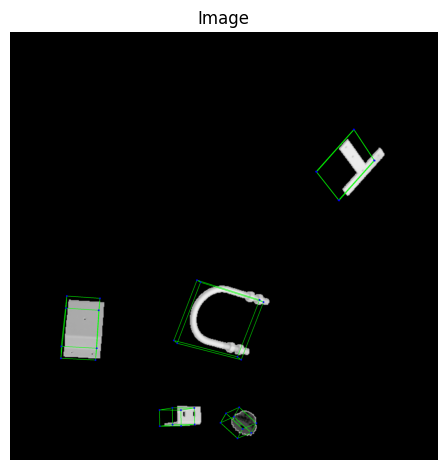

In [68]:
plt.figure()
plt.title("Image")
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


#### Model

In [16]:
class RGBPoseNet(nn.Module):
    def __init__(self): 
        super(RGBPoseNet, self).__init__()
        self.backbone = models.resnet18(weights='DEFAULT')  # updated to modern PyTorch
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 6)  # tx, ty, tz, yaw, pitch, roll
        )

    def forward(self, x):  
        feat = self.backbone(x)
        out = self.fc(feat)    
        return out


In [7]:
os.makedirs("checkpoints", exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = RGBPoseNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1.0 / 20))

total_train_loss = []
total_val_loss = []
num_epochs = 20

In [8]:
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for images_batch, _, _, _, R_6d_batch in tqdm(train_loader):
        rgb_stack = []
        pose_stack = []

        for b in range(len(images_batch)):  # e.g., 16
            rgb_list = images_batch[b]["rgb_cropped"]  
            pose_list = R_6d_batch[b] 

            rgb_stack.extend(rgb_list)
            pose_stack.extend(pose_list)

        rgb_batch = torch.stack(rgb_stack).to(device)  
        pose_batch = torch.stack(pose_stack).to(device) 
        pose_batch[:, :3] /= 1000.0  # normalizing

        # Forward
        pose_pred = net(rgb_batch)
        loss = criterion(pose_pred, pose_batch)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_avg_loss = running_loss / len(train_loader)
    total_train_loss.append(train_avg_loss)
    print(f"Train Loss: {train_avg_loss:.4f}")

    if ((epoch + 1) % 5 == 0) or (epoch == 0):
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images_batch, _, _, _, R_6d_batch in tqdm(val_loader):
                rgb_stack = []
                pose_stack = []
        
                for b in range(len(images_batch)):  # e.g., 16
                    rgb_list = images_batch[b]["rgb_cropped"]  
                    pose_list = R_6d_batch[b] 
        
                    rgb_stack.extend(rgb_list)
                    pose_stack.extend(pose_list)
        
                rgb_batch = torch.stack(rgb_stack).to(device)  
                pose_batch = torch.stack(pose_stack).to(device) 
                pose_batch[:, :3] /= 1000.0  # normalizing
        
                # Forward
                pose_pred = net(rgb_batch)
                loss = criterion(pose_pred, pose_batch)
                val_loss += loss.item()

            val_avg_loss = val_loss / len(val_loader)
            total_val_loss.append(val_avg_loss)
            print(f"Val Loss: {val_avg_loss:.4f}")

            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_avg_loss,
                "val_loss": val_avg_loss,
            }, f"checkpoints/pose_epoch{epoch+1}.pth")
    scheduler.step()



Epoch 1/20


100%|█████████████████████████████████| 19/19 [03:54<00:00, 12.32s/it]


Train Loss: 1.2782


100%|█████████████████████████████████| 19/19 [03:43<00:00, 11.75s/it]


Val Loss: 1.2628

Epoch 2/20


100%|████████████████| 19/19 [04:02<00:00, 12.77s/it]


Train Loss: 1.1626

Epoch 3/20


100%|████████████████| 19/19 [04:09<00:00, 13.14s/it]


Train Loss: 1.1761

Epoch 4/20


100%|████████████████| 19/19 [03:58<00:00, 12.53s/it]


Train Loss: 1.1628

Epoch 5/20


100%|████████████████| 19/19 [04:05<00:00, 12.92s/it]


Train Loss: 1.1539


100%|████████████████| 19/19 [03:51<00:00, 12.20s/it]


Val Loss: 1.1946

Epoch 6/20


100%|████████████████| 19/19 [04:09<00:00, 13.12s/it]


Train Loss: 1.1184

Epoch 7/20


100%|████████████████| 19/19 [04:05<00:00, 12.90s/it]


Train Loss: 1.0908

Epoch 8/20


100%|████████████████| 19/19 [04:12<00:00, 13.27s/it]


Train Loss: 1.0692

Epoch 9/20


100%|████████████████| 19/19 [04:05<00:00, 12.94s/it]


Train Loss: 1.0671

Epoch 10/20


100%|████████████████| 19/19 [03:53<00:00, 12.30s/it]


Train Loss: 1.0227


100%|████████████████| 19/19 [04:00<00:00, 12.64s/it]


Val Loss: 1.1462

Epoch 11/20


100%|████████████████| 19/19 [04:18<00:00, 13.60s/it]


Train Loss: 1.0330

Epoch 12/20


100%|█| 19/19 [0


Train Loss: 1.0321

Epoch 13/20


100%|█| 19/19 [0


Train Loss: 1.0230

Epoch 14/20


100%|█| 19/19 [0


Train Loss: 0.9919

Epoch 15/20


100%|█| 19/19 [0


Train Loss: 0.9686


100%|█| 19/19 [0


Val Loss: 1.1264

Epoch 16/20


100%|█| 19/19 [0


Train Loss: 0.9951

Epoch 17/20


100%|█| 19/19 [0


Train Loss: 0.9845

Epoch 18/20


100%|█| 19/19 [0


Train Loss: 0.9500

Epoch 19/20


100%|█| 19/19 [0


Train Loss: 0.9731

Epoch 20/20


100%|█| 19/19 [0


Train Loss: 0.9928


100%|█| 19/19 [0

Val Loss: 1.1171


#### Loss Plot

In [51]:
checkpoint_dir = "./checkpoints/pose_working"
epochs = []
train_losses = []
val_losses = []


# Make sure files are sorted by epoch number
files = sorted(os.listdir(checkpoint_dir), key=lambda x: int(x.split("_epoch")[1].split(".")[0]))

for file in files:
    if file.endswith(".pth"):
        path = os.path.join(checkpoint_dir, file)
        ckpt = torch.load(path, map_location='cpu')
        
        epochs.append(ckpt["epoch"])
        train_losses.append(ckpt["train_loss"])
        val_losses.append(ckpt["val_loss"])


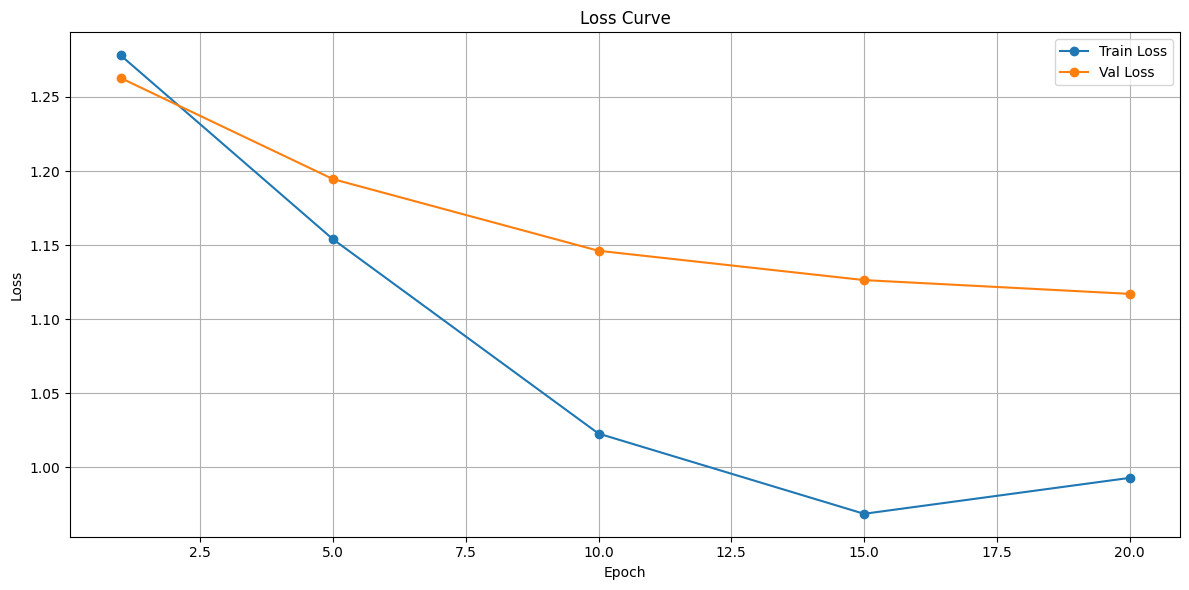

In [54]:
plt.figure(figsize=(12, 6))

# Plot losses
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_curve.png')  # Save to file
# plt.show()  # Optional: comment this out if running on headless server

#### Validating model

In [35]:
mesh = {0: trimesh.load('ipd/models/obj_000000.ply'), 
     1: trimesh.load('ipd/models/obj_000008.ply'),
     2: trimesh.load('ipd/models/obj_000018.ply'),
     3: trimesh.load('ipd/models/obj_000019.ply'),
     4: trimesh.load('ipd/models/obj_000020.ply'),
     5: trimesh.load('ipd/models/obj_000001.ply'),
     6: trimesh.load('ipd/models/obj_000004.ply'),
     7: trimesh.load('ipd/models/obj_000010.ply'),
     8: trimesh.load('ipd/models/obj_000011.ply'),
     9: trimesh.load('ipd/models/obj_000014.ply')}

with open("./ipd/camera_cam1.json") as cam1_int:
    cam1_internsics = json.load(cam1_int)
with open("./ipd/camera_cam2.json") as cam2_int:
    cam2_internsics = json.load(cam2_int)
with open("./ipd/camera_cam3.json") as cam3_int:
    cam3_internsics = json.load(cam3_int)
camera_internsics = {"cam1":cam1_internsics,"cam2":cam2_internsics,"cam3":cam3_internsics}


In [36]:
# Get a single batch
images_batch, targets_batch, camera_batch, camera_transforms_batch, R_6d_batch = next(iter(test_loader))
batch_size = len(images_batch)
idx = random.randint(0, batch_size - 1)

In [37]:
# predicting Pose
rgb_stack = []
rgb_list = images_batch[idx]["rgb_cropped"]  
rgb_stack.extend(rgb_list)
rgb_batch = torch.stack(rgb_stack).to(device)  
net.eval()
with torch.no_grad():
    pose_pred = net(rgb_batch)
pose_pred[:, :3]  *= 1000

In [38]:
# Getting GT values
original_image = images_batch[idx]["rgb"].permute(1, 2, 0).cpu().numpy()
image = cv2.resize(original_image, (2400, 2400), interpolation=cv2.INTER_LINEAR)
targets = targets_batch[idx]
gt_dof = R_6d_batch[idx]
camera_info = camera_batch[idx]
intr = camera_internsics[camera_info]

In [39]:
pose_pred[0]

tensor([ 3.3145e+00,  3.9415e+01,  1.5035e+03,  1.9082e+00, -3.0964e-02, -4.5367e-03], device='cuda:0')

In [40]:
gt_dof[0]

tensor([-2.7584e+02, -4.4412e+01,  1.5110e+03,  1.4093e+00,  2.1203e-01, -3.0339e+00])

In [41]:
fx, fy, cx, cy = intr["fx"], intr["fy"], intr["cx"], intr["cy"]

orig_width = 3840
orig_height = 2160
new_width = 2400
new_height = 2400     
offset = -70
# Cropping offset
crop_offset_x = ((orig_width - new_width) / 2) - offset  
crop_offset_y = (orig_height - new_height) / 2 

cx_new = cx - crop_offset_x
cy_new = cy  - crop_offset_y
fx_new = fx
fy_new = fy

K = np.array([[fx_new, 0, cx_new],
              [0, fy_new, cy_new],
              [0,  0,  1]], dtype=np.float32)

gt_image = image
predicted_image = image

for i,d in enumerate(gt_dof):
    class_id = int(targets[i][0])  
    # calculate rotation matrix and transpose matrix from 6dof
    # GT
    pose = np.array(d, dtype=np.float32)
    tvec = pose[:3]  
    euler = pose[3:] 
    rvec = R.from_euler('zyx', euler, degrees=False).as_matrix()  

    # pred
    pred_pose = np.array(d, dtype=np.float32)
    pred_tvec = pred_pose[:3]  
    pred_euler = pred_pose[3:] 
    pred_rvec = R.from_euler('zyx', pred_euler, degrees=False).as_matrix()  

    # get edge points
    obj_mesh = mesh[class_id]
    vertices = np.array(obj_mesh.vertices) # shape (N, 3)
    min_bound = vertices.min(axis=0)
    max_bound = vertices.max(axis=0)
    # Generate 8 corner points from min and max bounds
    xs = [min_bound[0], max_bound[0]]
    ys = [min_bound[1], max_bound[1]]
    zs = [min_bound[2], max_bound[2]]
    bbox_corners_3d = np.array([[x,y,z] for x in xs for y in ys for z in zs],
    dtype=np.float32)


    proj, _ = cv2.projectPoints(bbox_corners_3d, rvec, tvec, K, distCoeffs=None)
    proj = proj.reshape(-1, 2)    # (8, 2)   in pixel space

    pred_proj, _ = cv2.projectPoints(bbox_corners_3d, pred_rvec, pred_tvec, K, distCoeffs=None)
    pred_proj = pred_proj.reshape(-1, 2)    # (8, 2)   in pixel space
    edges = [(0,1), (0,2), (0,4), (1,3), (1,5),
             (2,3), (2,6), (3,7), (4,5), (4,6), (5,7), (6,7)]
    
    for i, j in edges:
        p1, p2 = tuple(proj[i].astype(int)), tuple(proj[j].astype(int))
        cv2.line(gt_image, p1, p2, (0, 255, 0), 2)

    for i, j in edges:
        p1, p2 = tuple(pred_proj[i].astype(int)), tuple(pred_proj[j].astype(int))
        cv2.line(predicted_image, p1, p2, (0, 255, 0), 2)
    
    for (x, y) in proj.astype(int):
        cv2.circle(gt_image, (x, y), 5, (0, 0, 255), -1)
        
    for (x, y) in pred_proj.astype(int):
        cv2.circle(predicted_image, (x, y), 5, (0, 0, 255), -1)
    

/tmp/ipykernel_100251/3860772831.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pose = np.array(d, dtype=np.float32)
/tmp/ipykernel_100251/3860772831.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pred_pose = np.array(d, dtype=np.float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


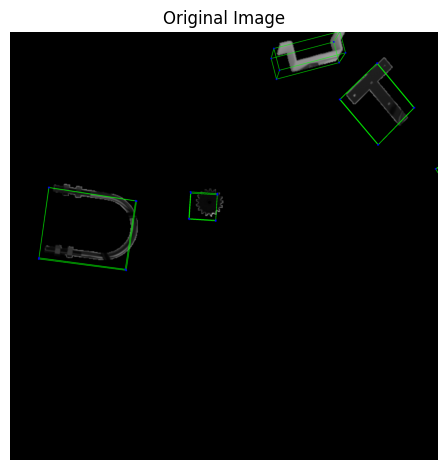

In [44]:
plt.figure()
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


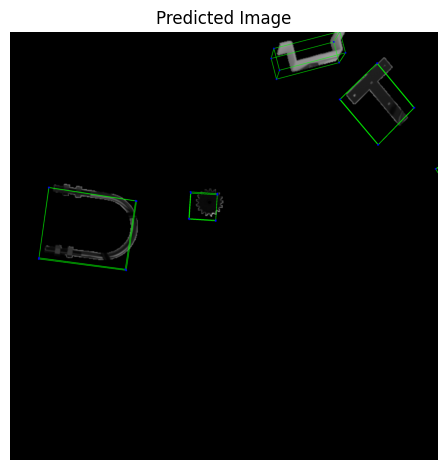

In [45]:
plt.figure()
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.axis('off')
plt.tight_layout()
plt.show()


#### Model combination

In [117]:
from ultralytics import YOLO
from ultralytics.models.yolo.model import Model
from ultralytics.nn.modules.conv import Concat
from ultralytics.nn.tasks import attempt_load_one_weight
from ultralytics.nn.modules.head import Detect
from ultralytics.utils.loss import v8DetectionLoss  # or E2EDetectLoss
from scipy.spatial.transform import Rotation as R
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.ops import nms
from torch.utils.data import DataLoader
import torchvision.models as models

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
from copy import deepcopy
import cv2
from types import SimpleNamespace
import math
import os

Loading RGB Model

In [118]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net       = fused_bbox_model(nc=10).to(device)
ckpt = torch.load("ckpt_epoch25.pt")
net.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

##### Getting single batch data to test our combination model

In [119]:
# Get a single batch
images_batch, targets_batch, camera_batch, camera_transforms_batch, R_6d_batch = next(iter(test_loader))
batch_size = len(images_batch)
idx = random.randint(0, batch_size - 1)

In [120]:
sample = images_batch[idx]
# make a batch of size 1
imgs = {
    k: sample[k].unsqueeze(0).to(device)   
    for k in ["rgb", "depth"]
}

net.eval()
with torch.no_grad():
    preds = net(imgs)            # list of 3 scales
    raw = preds[1]               # pick the middle scale (as in val code)

pred_dicts = decode_and_nms(
    raw,
    reg_max=16,
    num_classes=10,
    conf_thres=0.9,
    iou_thres=0.2
)

preds0 = pred_dicts[0]

Predicted BBoxes

In [121]:
preds0

{'boxes': tensor([[0.4127, 0.5900, 0.5738, 0.7481],
         [0.7657, 0.2531, 0.8718, 0.3744],
         [0.1294, 0.6217, 0.2192, 0.7622],
         [0.5155, 0.8859, 0.5750, 0.9394],
         [0.3654, 0.8692, 0.4412, 0.9217],
         [0.5502, 0.6003, 0.6047, 0.6397]], device='cuda:0'),
 'scores': tensor([0.9998, 0.9992, 0.9978, 0.9899, 0.9763, 0.9176], device='cuda:0'),
 'labels': tensor([3, 2, 4, 1, 0, 1], device='cuda:0')}

##### Showcasing Predictions

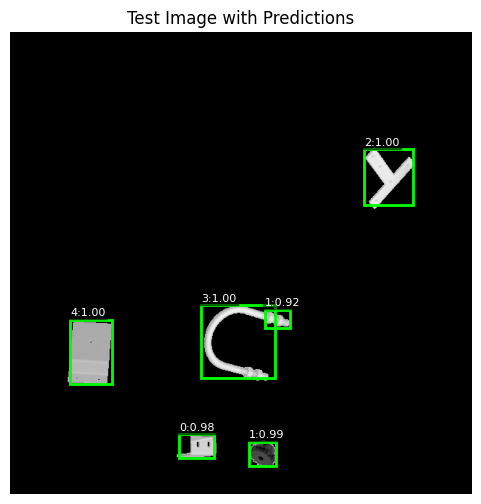

In [122]:
img_tensor = sample["rgb"]            # shape (3, H, W)
img_np = img_tensor.permute(1, 2, 0)  # (H, W, 3)
img_np = img_np.cpu().numpy()         # numpy array
H, W, _ = img_np.shape


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img_np)
ax.set_title("Test Image with Predictions")
ax.axis("off")

for box, score, cls in zip(preds0["boxes"], preds0["scores"], preds0["labels"]):
    x1, y1, x2, y2 = box.tolist()
    # convert to pixel coords
    x1 *= W; y1 *= H
    x2 *= W; y2 *= H
    width  = x2 - x1
    height = y2 - y1

    rect = plt.Rectangle(
        (x1, y1), width, height,
        linewidth=2, edgecolor="lime", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1 - 5,
        f"{int(cls)}:{score:.2f}",
        color="white", fontsize=8,
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )

plt.show()


##### Cropping images to run pose prediction

In [123]:
original_image = images_batch[idx]["rgb"].permute(1, 2, 0).cpu().numpy()
image = cv2.resize(original_image, (2400, 2400), interpolation=cv2.INTER_LINEAR)
margin = 10
h,  w   = 2400, 2400
bboxes = preds0['boxes']
bboxes = bboxes * torch.tensor([w, h, w, h], device=bboxes.device)
classes = preds0['labels']
imgs = []
input_size = 240

for box in bboxes:
    x1,y1,x2,y2 = box
    x_min, y_min = int(max(0, x1 - margin)), int(max(0, y1 - margin))
    x_max, y_max = int(min(w - 1, x2 + margin)), int(min(h - 1, y2 + margin))

    
    crop_rgb = image[y_min:y_max+1, x_min:x_max+1]
    crop_h, crop_w = crop_rgb.shape[0], crop_rgb.shape[1]
    
    crop_rgb_resized = cv2.resize(crop_rgb, (input_size, input_size),interpolation=cv2.INTER_LINEAR)
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    
    tensor_transform = T.Compose([T.ToTensor(), 
                                            normalize,
                                            ])
    input_tensor = tensor_transform(crop_rgb_resized)
    imgs.append(input_tensor)


Pose model

In [124]:
mesh = {0: trimesh.load('ipd/models/obj_000000.ply'), 
     1: trimesh.load('ipd/models/obj_000008.ply'),
     2: trimesh.load('ipd/models/obj_000018.ply'),
     3: trimesh.load('ipd/models/obj_000019.ply'),
     4: trimesh.load('ipd/models/obj_000020.ply'),
     5: trimesh.load('ipd/models/obj_000001.ply'),
     6: trimesh.load('ipd/models/obj_000004.ply'),
     7: trimesh.load('ipd/models/obj_000010.ply'),
     8: trimesh.load('ipd/models/obj_000011.ply'),
     9: trimesh.load('ipd/models/obj_000014.ply')}

with open("./ipd/camera_cam1.json") as cam1_int:
    cam1_internsics = json.load(cam1_int)
with open("./ipd/camera_cam2.json") as cam2_int:
    cam2_internsics = json.load(cam2_int)
with open("./ipd/camera_cam3.json") as cam3_int:
    cam3_internsics = json.load(cam3_int)
camera_internsics = {"cam1":cam1_internsics,"cam2":cam2_internsics,"cam3":cam3_internsics}


In [125]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pose_net = RGBPoseNet().to(device)
ckpt = torch.load("pose_epoch20.pth")
pose_net.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [126]:
# predicting Pose
rgb_stack = []
rgb_stack.extend(imgs)
rgb_batch = torch.stack(rgb_stack).to(device)  
pose_net.eval()
with torch.no_grad():
    pose_pred = pose_net(rgb_batch)
pose_pred[:, :3]  *= 1000

In [127]:
pose_pred

tensor([[-1.2092e+01,  1.7858e+01,  1.5987e+03,  2.6379e-01, -1.2453e-01,  4.6236e-01],
        [ 6.6257e+01,  4.1434e+00,  1.5848e+03,  6.7534e-01,  1.2754e-02,  1.7143e-01],
        [-1.8682e+02,  8.7616e+00,  1.6816e+03,  9.4367e-03, -1.4484e-02,  8.2996e-03],
        [ 2.3469e+01, -1.1967e+02,  1.4578e+03, -1.2169e+00,  8.8014e-02, -1.6555e-02],
        [-1.7966e+01,  1.0943e+02,  1.6318e+03, -3.4488e-01,  1.6936e-01, -5.0685e-01],
        [-1.8338e+02,  4.1362e+01,  1.6732e+03, -9.0991e-01, -1.0470e-01,  3.9619e-02]], device='cuda:0')

In [128]:
# Getting GT values
targets = targets_batch[idx]
gt_dof = R_6d_batch[idx]
camera_info = camera_batch[idx]
intr = camera_internsics[camera_info]

In [129]:
fx, fy, cx, cy = intr["fx"], intr["fy"], intr["cx"], intr["cy"]

orig_width = 3840
orig_height = 2160
new_width = 2400
new_height = 2400     
offset = -70
# Cropping offset
crop_offset_x = ((orig_width - new_width) / 2) - offset  
crop_offset_y = (orig_height - new_height) / 2 

cx_new = cx - crop_offset_x
cy_new = cy  - crop_offset_y
fx_new = fx
fy_new = fy

K = np.array([[fx_new, 0, cx_new],
              [0, fy_new, cy_new],
              [0,  0,  1]], dtype=np.float32)

gt_image = image.copy()
predicted_image = image.copy()

for i,d in enumerate(gt_dof):
    class_id = int(targets[i][0])  
    predicted_id = int(classes[i])  
    # calculate rotation matrix and transpose matrix from 6dof
    # GT
    pose = np.array(d, dtype=np.float32)
    tvec = pose[:3]  
    euler = pose[3:] 
    rvec = R.from_euler('zyx', euler, degrees=False).as_matrix()  

    # pred
    pred_pose = np.array(d, dtype=np.float32)
    pred_tvec = pred_pose[:3]  
    pred_euler = pred_pose[3:] 
    pred_rvec = R.from_euler('zyx', pred_euler, degrees=False).as_matrix()  

    # get edge points
    obj_mesh = mesh[class_id]
    vertices = np.array(obj_mesh.vertices) # shape (N, 3)
    min_bound = vertices.min(axis=0)
    max_bound = vertices.max(axis=0)
    # Generate 8 corner points from min and max bounds
    xs = [min_bound[0], max_bound[0]]
    ys = [min_bound[1], max_bound[1]]
    zs = [min_bound[2], max_bound[2]]
    bbox_corners_3d = np.array([[x,y,z] for x in xs for y in ys for z in zs],
    dtype=np.float32)

    # get edge points
    pred_obj_mesh = mesh[predicted_id]
    pred_vertices = np.array(pred_obj_mesh.vertices) # shape (N, 3)
    pred_min_bound = pred_vertices.min(axis=0)
    pred_max_bound = pred_vertices.max(axis=0)
    # Generate 8 corner points from min and max bounds
    pred_xs = [pred_min_bound[0], pred_max_bound[0]]
    pred_ys = [pred_min_bound[1], pred_max_bound[1]]
    pred_zs = [pred_min_bound[2], pred_max_bound[2]]
    pred_bbox_corners_3d = np.array([[x,y,z] for x in pred_xs for y in pred_ys for z in pred_zs],
    dtype=np.float32)


    proj, _ = cv2.projectPoints(bbox_corners_3d, rvec, tvec, K, distCoeffs=None)
    proj = proj.reshape(-1, 2)    # (8, 2)   in pixel space

    pred_proj, _ = cv2.projectPoints(pred_bbox_corners_3d, pred_rvec, pred_tvec, K, distCoeffs=None)
    pred_proj = pred_proj.reshape(-1, 2)    # (8, 2)   in pixel space
    edges = [(0,1), (0,2), (0,4), (1,3), (1,5),
             (2,3), (2,6), (3,7), (4,5), (4,6), (5,7), (6,7)]
    
    # for i, j in edges:
    #     p1, p2 = tuple(proj[i].astype(int)), tuple(proj[j].astype(int))
    #     cv2.line(gt_image, p1, p2, (255, 0, 0), 2)

    for i, j in edges:
        p1, p2 = tuple(pred_proj[i].astype(int)), tuple(pred_proj[j].astype(int))
        cv2.line(predicted_image, p1, p2, (0, 255, 0), 2)
    
    # for (x, y) in proj.astype(int):
    #     cv2.circle(gt_image, (x, y), 5, (0, 0, 255), -1)
        
    for (x, y) in pred_proj.astype(int):
        cv2.circle(predicted_image, (x, y), 5, (0, 0, 255), -1)
    

/tmp/ipykernel_87491/3152555014.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pose = np.array(d, dtype=np.float32)
/tmp/ipykernel_87491/3152555014.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pred_pose = np.array(d, dtype=np.float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


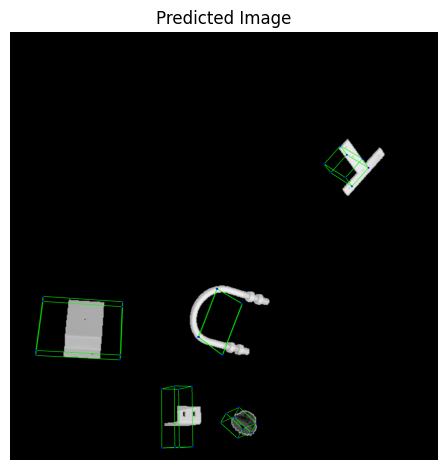

In [130]:
plt.figure()
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.axis('off')
plt.tight_layout()
plt.show()
